In [1]:
window = 100
device = 'cuda'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import least_squares
import yfinance as yf
import torch
import torch.nn as nn

from model.neural_net import *
from model.data import *
from model.train import *

# Download data

In [3]:
train_dataset_start_date = pd.to_datetime('1995-01-01').date()
valid_start_date = pd.to_datetime('2015-01-01').date()
test_start_date = pd.to_datetime('2019-01-01').date()
test_end_date = pd.to_datetime('2023-08-31').date()

In [4]:
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=train_dataset_start_date, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=train_dataset_start_date, end=test_end_date)

In [5]:
# spx_data.to_csv('spx_data_nn.csv')
# vix_data.to_csv('vix_data_nn.csv')

In [6]:
spx_data = pd.read_csv('spx_data_nn.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('vix_data_nn.csv', index_col=0, parse_dates=[0])

In [7]:
spx_data.index = pd.to_datetime(pd.to_datetime(spx_data.index, utc=True).date)
vix_data.index = pd.to_datetime(pd.to_datetime(vix_data.index, utc=True).date)

In [8]:
train_start_date = spx_data.index[window-1]
valid_start_index = spx_data.index.get_indexer([valid_start_date], method='bfill').item()
test_start_index = spx_data.index.get_indexer([test_start_date], method='bfill').item()
test_end_index = spx_data.index.get_indexer([test_end_date], method='bfill').item()
valid_dataset_start_date = spx_data.index[valid_start_index - (window - 1)].date()
test_dataset_start_date = spx_data.index[test_start_index - (window - 1)].date()
print(f"Train dataset start date: {train_dataset_start_date}")
print(f"Train start date: {train_start_date}")
print(f"Valid dataset start date: {valid_dataset_start_date}")
print(f"Valid start date: {valid_start_date}")
print(f"Test dataset start date: {test_dataset_start_date}")
print(f"Test start date: {test_start_date}")
print(f"Test end date: {test_end_date}")

Train dataset start date: 1995-01-01
Train start date: 1995-05-24 00:00:00
Valid dataset start date: 2014-08-12
Valid start date: 2015-01-01
Test dataset start date: 2018-08-09
Test start date: 2019-01-01
Test end date: 2023-08-31


In [9]:
train_data = create_df_from_yf(spx_data, vix_data, train_dataset_start_date, valid_start_date)
valid_data = create_df_from_yf(spx_data, vix_data, valid_dataset_start_date, test_start_date)
test_data = create_df_from_yf(spx_data, vix_data, test_dataset_start_date, test_end_date)
train_dataset = VIXDataset2(train_data, window)
valid_dataset = VIXDataset2(valid_data, window)
test_dataset = VIXDataset2(test_data, window)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Fitting

In [10]:
# model = MLPModel(4*window-1, [256, 128, 64], 1, activation=nn.Tanh())
model = TModel(window, window-1, n_transformer_layers=1, kernel_size=3, stride=1, embedding_dim=8, n_head=2, mlp_dims=[1024, 256, 64])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)
loss_fn = nn.MSELoss()
trainer = MSETrainer(model, optimizer, loss_fn, train_loader, scheduler, valid_dataloader=valid_loader, test_dataloader=test_loader, device=device)
trainer.fit(100, model_name='Transformer_v1')

Epoch 1
Training phase: train_loss: 0.05023 
Validation phase: valid_loss: 0.00403 
Saving model


KeyboardInterrupt: 

In [19]:
residuals = []
for x, y in train_loader:
    x, y = x.to(torch.float32), y.to(torch.float32)
    residual = y - model(x).squeeze()
    residuals.append(torch.flatten(residual))
residuals = torch.cat(residuals).detach().numpy()
residuals.shape

(4936,)

In [20]:
total_sum_of_squares = np.sum((train_data.iloc[window-1:]['vix'] - np.mean(train_data.iloc[window-1:]['vix'])) ** 2)
print('Mean: {:.4f}, Min: {:.4f}, Max: {:.4f}, MAE: {:.4f}, MSE: {:.4f}, R^2: {:.4f}'.format(
    np.mean(residuals), np.min(residuals), np.max(residuals), np.mean(np.abs(residuals)), np.mean(residuals**2), (1-np.sum(residuals**2)/total_sum_of_squares)))

Mean: 0.0023, Min: -0.0882, Max: 0.1638, MAE: 0.0101, MSE: 0.0002, R^2: 0.9680


# Predicting out of sample

In [14]:
model.load_state_dict(torch.load('./weights/model_MLP_v1.pt'))

<All keys matched successfully>

In [21]:
data = create_dataset_from_yf_df(spx_data, vix_data, train_dataset_start_date, test_end_date)
data

,r1,r2,vix
1995-01-04,0.003485,1.214534e-05,0.1353
1995-01-05,-0.000803,6.449659e-07,0.1350
1995-01-06,0.000739,5.454954e-07,0.1313
1995-01-09,0.000326,1.060104e-07,0.1333
1995-01-10,0.001845,3.402222e-06,0.1252
...,...,...,...
2023-08-24,-0.013458,1.811171e-04,0.1720
2023-08-25,0.006718,4.513107e-05,0.1568
2023-08-28,0.006265,3.924546e-05,0.1508
2023-08-29,0.014508,2.104910e-04,0.1445


In [22]:
dataset = VIXDataset2(data, window)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
preds = []
for x, y in dataloader:     
    preds.append(model(x).squeeze().detach().numpy())
preds = np.concatenate(preds)
df_preds = data[window-1:].copy()
df_preds['preds'] = preds
df_preds

,r1,r2,vix,preds
1995-05-25,-0.000038,1.425558e-09,0.1163,0.129833
1995-05-26,-0.009346,8.734065e-05,0.1220,0.135645
1995-05-30,-0.000134,1.787330e-08,0.1252,0.136202
1995-05-31,0.018756,3.517689e-04,0.1285,0.126529
1995-06-01,0.000169,2.844782e-08,0.1221,0.127972
...,...,...,...,...
2023-08-24,-0.013458,1.811171e-04,0.1720,0.169538
2023-08-25,0.006718,4.513107e-05,0.1568,0.159394
2023-08-28,0.006265,3.924546e-05,0.1508,0.149647
2023-08-29,0.014508,2.104910e-04,0.1445,0.133837


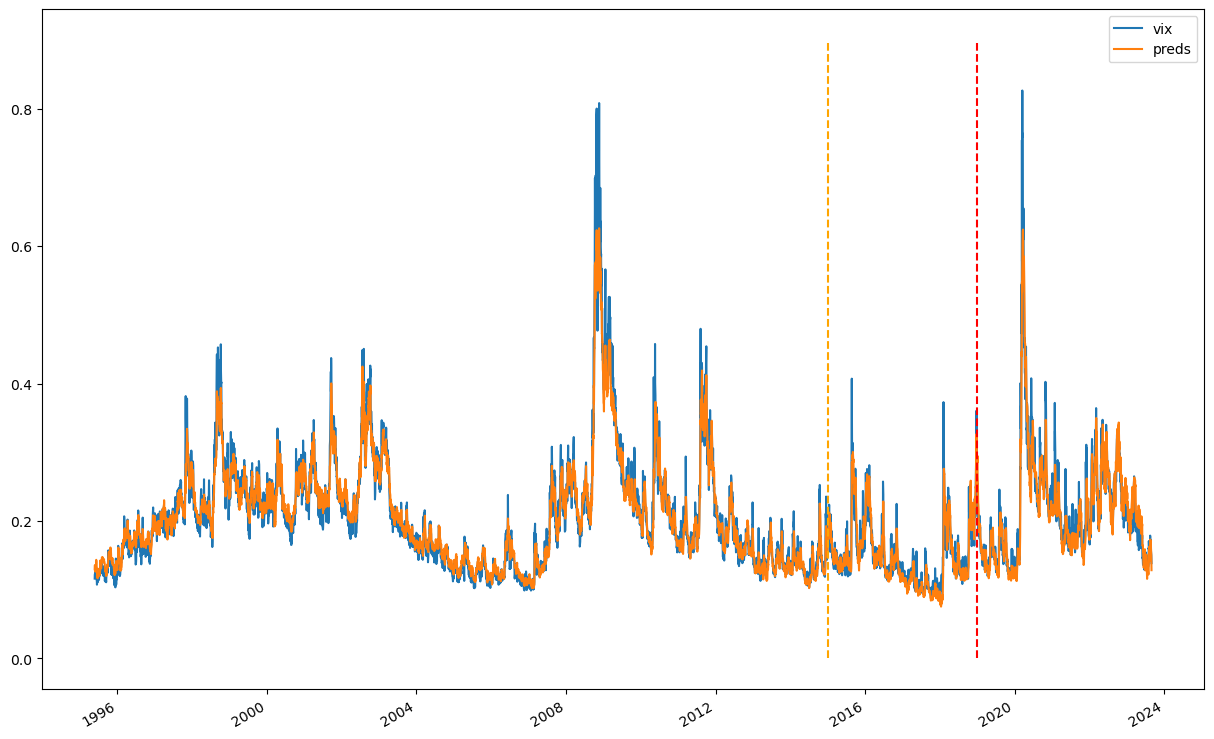

In [23]:
df_preds[['vix', 'preds']].plot(figsize=(15, 10))
plt.vlines(valid_start_date, 0, 0.9, linestyles='dashed', colors='orange')
plt.vlines(test_start_date, 0, 0.9, linestyles='dashed', colors='red')

In [25]:
residuals = df_preds['vix'] - df_preds['preds']
residuals = residuals[test_start_date:].values
total_sum_of_squares = np.sum((data.loc[test_start_date:, 'vix'] - np.mean(data.loc[test_start_date:, 'vix'])) ** 2)
print('Mean: {:.4f}, Min: {:.4f}, Max: {:.4f}, MAE: {:.4f}, MSE: {:.4f}, R^2: {:.4f}'.format(
    np.mean(residuals), np.min(residuals), np.max(residuals), np.mean(np.abs(residuals)), np.mean(residuals**2), (1-np.sum(residuals**2)/total_sum_of_squares)))

Mean: 0.0020, Min: -0.1028, Max: 0.2460, MAE: 0.0156, MSE: 0.0006, R^2: 0.9161
